# **SPECIAL TOPICS PROJECT NOTEBOOK**
## 'Classification of Modern Sculpture Using Convolutional Neural Networks'
### Anouk Flinkert, s2313820
### Leiden University Centre for Digital Humanities
### 26-6-2023



---

In this project, I attempted to employ a Deep Learning algorithm known as a Convolutional Neural Network (CNN), to classify the types of sculpture in BaZ’s collection using the Transfer Learning technique on a pre-trained model.

The pre-trained CNN used:
* EfficientNet_B0_Weights.IMAGENET1K_V1

The dataset's classes:
1.   bust
2.   figure
3.  fragment
4. geometric form
5. head
6. installation
7. organic form
8. relievo


The following code can only be run through access to the custom dataset 'baz_dataset_V1'.







Deliberate decisions on for example hyperparameters and interpretation of the results are reported in the final report.

## 0. Importing relevant libraries and configuration to the Wandb API

In [ ]:
# If not already installed, uncomment line below
# !pip install torchmetrics

In [ ]:
# If not already installed, uncomment line below
# !pip install wandb

In [ ]:
# Necessary imports for image classification and visualizations using torchvision
import matplotlib.pyplot as plt
import os
import torch
import torchvision
import torch.utils.data as data_utils

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch import nn
from torchvision import transforms, datasets
from torchmetrics.classification import MulticlassAccuracy as Accuracy

# # Wandb API for tracking model performance and metrics in wandb.ai environment
# import wandb

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
# Check the device
device

# Key saved in environment to automatically login to user profile
os.environ["WANDB_API_KEY"] = "42f496848618e2655c524b7fbd255b7f5c476f31"

wandb.login()
wandb.init(
    project='Baz_Classification'

)

'cpu'

In [ ]:
# Wandb configuration that helps regulating epochs and batch_size
config = {
    'epochs': 50,
    'batch_size': 32
}


## 1. Data preperation

### 1.1 Defining the manual transforms applied to the data

For documentation on the utilized augmentation TrivialAugmentWide: https://pytorch.org/vision/main/generated/torchvision.transforms.TrivialAugmentWide.html

In [ ]:
from torchvision import transforms

# Define function for manually created transformation to data
manual_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Reshape all images to 224x224
    transforms.Grayscale(num_output_channels=3), # Turns data into grayscale images for algorithmic simplification and reduces computation time
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # Slightly alters images, creating more data for the model to make predictions on
    transforms.ToTensor(), # Turn image values to between 0 & 1
])


### 1.2 Downloading data to the Torchvision environment

In [ ]:
# Setup training data using the built-in ImageFolder function of the torchvision library
train_data = torchvision.datasets.ImageFolder(
    root=r"D:\Special Topics project\datasets\baz_dataset_V1\train", # Give the path to the dataset directory -> stored on local storage
    transform=manual_transform, # Use manual_transform on data
    target_transform=None # Don't transform labels
)

# Setup testing data
test_data = torchvision.datasets.ImageFolder(
    root=r"D:\Special Topics project\datasets\baz_dataset_V1\test",
    transform=manual_transform # Use the transform for test
)

# Define and create a list of the classes
class_names = train_data.classes

### 1.3 Dataloaders

In [ ]:
from torch.utils.data import DataLoader

# Turns the dataset into iterable batches
train_dataloader = DataLoader(train_data,
    batch_size=config['batch_size'], # Batch size is predefined using the wandb configuration
    shuffle=True # Shuffles data in batches every epoch to prevent overfitting in a multiclass dataset
)

test_dataloader = DataLoader(test_data,
    batch_size=config['batch_size'],
    shuffle=False
)


## 2. Loading the pre-trained model 'EfficientNet_B0'


In [ ]:
# Load the model with pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT  # .DEFAULT = best available weights for specific model
model = torchvision.models.efficientnet_b0(weights=weights).to(device) # Send it to the target devic

# Investigates the model
model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 2.1 Adjusting the classifyer to the amount of classes in the baz dataset

In [ ]:
# Calling last layer
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names)) # Adjusting the out_features to the number of classes
)

### 2.2 Transfer Learning

In [ ]:
# Loop through the model's layers
for name, param in model.named_parameters():
  # If 'classifier' not in name, if so, disable/'freeze' the layer
  if 'classifier' not in name:
    param.requires_grad = False
  print(name, param.requires_grad)

## 3. Training the model

### 3.1 Define the loss, optimizer and accuracy metric from torchmetrics

In [ ]:
# Define loss function for multiclass classification
loss_fn = nn.CrossEntropyLoss()
# Set up the Adam optimizer along with the Karpathy learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# Use accuracy function from torchmetrics
accuracy_fn = Accuracy(num_classes=len(class_names))

### 3.2 Training and testing loop

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Create training and testing loop
for epoch in tqdm(range(config['epochs'])):
    print(f"Epoch: {epoch}\n-------")
    ### Training
    train_loss = 0
    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        # Send data to device
        X, y = X.to(device), y.to(device)
        # Send model to device
        model.to(device)
        # Enable training mode
        model.train()
        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Print out how many samples have been seen
        print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    # Put model in evaluation mode
    model.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += accuracy_fn(test_pred.argmax(dim=1).cpu(), y.cpu())

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    # Log results in wandb environment
    wandb.log({'train_loss':train_loss, 'test_loss':test_loss, 'test_accuracy':test_acc})
    ## Print out the results
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}\n")

wandb.finish()

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 2.08404 | Test loss: 2.04446, Test acc: 0.05

Epoch: 1
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.98299 | Test loss: 1.97450, Test acc: 0.09

Epoch: 2
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.89864 | Test loss: 1.93401, Test acc: 0.09

Epoch: 3
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.82698 | Test loss: 1.89206, Test acc: 0.10

Epoch: 4
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.76708 | Test loss: 1.84868, Test acc: 0.13

Epoch: 5
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.70866 | Test loss: 1.80352, Test acc: 0.13

Epoch: 6
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.64363 | Test loss: 1.76354, Test acc: 0.12

Epoch: 7
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.61154 | Test loss: 1.71306, Test acc: 0.13

Epoch: 8
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.58438 | Test loss: 1.76113, Test acc: 0.11

Epoch: 9
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.53129 | Test loss: 1.66669, Test acc: 0.13

Epoch: 10
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.49461 | Test loss: 1.66257, Test acc: 0.11

Epoch: 11
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.45846 | Test loss: 1.62697, Test acc: 0.12

Epoch: 12
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.43285 | Test loss: 1.62644, Test acc: 0.13

Epoch: 13
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.41989 | Test loss: 1.64006, Test acc: 0.12

Epoch: 14
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.34979 | Test loss: 1.60710, Test acc: 0.13

Epoch: 15
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.33748 | Test loss: 1.55241, Test acc: 0.14

Epoch: 16
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.34328 | Test loss: 1.56417, Test acc: 0.13

Epoch: 17
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.28075 | Test loss: 1.51996, Test acc: 0.14

Epoch: 18
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.28685 | Test loss: 1.60090, Test acc: 0.14

Epoch: 19
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.25773 | Test loss: 1.54545, Test acc: 0.15

Epoch: 20
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.24148 | Test loss: 1.59003, Test acc: 0.14

Epoch: 21
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.23832 | Test loss: 1.49584, Test acc: 0.14

Epoch: 22
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.20800 | Test loss: 1.56711, Test acc: 0.13

Epoch: 23
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.18885 | Test loss: 1.52679, Test acc: 0.14

Epoch: 24
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.19347 | Test loss: 1.50248, Test acc: 0.14

Epoch: 25
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.16077 | Test loss: 1.47593, Test acc: 0.16

Epoch: 26
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.15296 | Test loss: 1.43496, Test acc: 0.17

Epoch: 27
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.16559 | Test loss: 1.47373, Test acc: 0.16

Epoch: 28
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.13751 | Test loss: 1.48856, Test acc: 0.14

Epoch: 29
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.09408 | Test loss: 1.49615, Test acc: 0.16

Epoch: 30
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.09365 | Test loss: 1.41244, Test acc: 0.17

Epoch: 31
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.10076 | Test loss: 1.43042, Test acc: 0.17

Epoch: 32
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.10647 | Test loss: 1.43936, Test acc: 0.14

Epoch: 33
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.09898 | Test loss: 1.40178, Test acc: 0.16

Epoch: 34
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.03470 | Test loss: 1.43539, Test acc: 0.15

Epoch: 35
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.10444 | Test loss: 1.41725, Test acc: 0.14

Epoch: 36
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.06524 | Test loss: 1.44585, Test acc: 0.15

Epoch: 37
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.05190 | Test loss: 1.45907, Test acc: 0.14

Epoch: 38
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.06967 | Test loss: 1.48901, Test acc: 0.13

Epoch: 39
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.05909 | Test loss: 1.42436, Test acc: 0.15

Epoch: 40
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.03537 | Test loss: 1.45293, Test acc: 0.13

Epoch: 41
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.02438 | Test loss: 1.48150, Test acc: 0.14

Epoch: 42
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.99280 | Test loss: 1.39233, Test acc: 0.15

Epoch: 43
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.02018 | Test loss: 1.45435, Test acc: 0.14

Epoch: 44
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.97947 | Test loss: 1.43347, Test acc: 0.14

Epoch: 45
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.99773 | Test loss: 1.39018, Test acc: 0.16

Epoch: 46
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.98001 | Test loss: 1.39175, Test acc: 0.17

Epoch: 47
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 1.01061 | Test loss: 1.40960, Test acc: 0.14

Epoch: 48
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.98991 | Test loss: 1.45727, Test acc: 0.13

Epoch: 49
-------


Looked at 0/503 samples


Looked at 32/503 samples


Looked at 64/503 samples


Looked at 96/503 samples


Looked at 128/503 samples


Looked at 160/503 samples


Looked at 192/503 samples


Looked at 224/503 samples


Looked at 256/503 samples


Looked at 288/503 samples


Looked at 320/503 samples


Looked at 352/503 samples


Looked at 384/503 samples


Looked at 416/503 samples


Looked at 448/503 samples


Looked at 345/503 samples



Train loss: 0.93247 | Test loss: 1.44704, Test acc: 0.16



test_accuracy,▁▃▃▄▆▅▆▅▄▅▆▅▆▅▆▆▆▆▅▆▇█▇▆██▆▇▆▇▆▆▆▆▇▆██▆▇
test_loss,█▇▇▆▅▅▄▅▄▄▄▄▃▃▂▃▃▂▃▂▂▁▂▂▁▁▂▁▁▂▂▂▂▂▁▂▁▁▁▂
train_loss,█▇▇▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
test_accuracy,0.15636
test_loss,1.44704
train_loss,0.93247


## 4. Model evaluations and predictions

### 4.1 Create predictions

In [ ]:
# Define function for making predictions
def make_predictions(model: nn.Module,
                     data: list,
                     device: torch.device = device):

  # Create an empty list for prediction probabilities
  pred_probs = []
  # Send model to device
  model.to(device)
  # Enable evaluation mode
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model output raw logits)
      pred_logits = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)


In [ ]:
# Checks the image shape and dimensions
# img, label = test_data[0][:10]
# img.shape, label


(torch.Size([3, 224, 224]), 0)

### 4.2 Plot predictions

In [ ]:
import random

# Generates the same random sample
random.seed(25)

# List for prediction samples
test_samples = []
# Ground truth, the label the sample should be sorted in
test_labels = []
# Append 9 random samples to the lists
for sample, label in random.sample(list(test_data), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# View the sample shape
# test_samples[0].shape


In [ ]:
# Make predictions
pred_probs = make_predictions(model=model,
                              data=test_samples)

# Convert probabilities to prediction labels using ArgMax -> take the index of the value of the pred_probs is the highest
pred_classes = pred_probs.argmax(dim=1)
# print(pred_classes)
# print(test_labels)


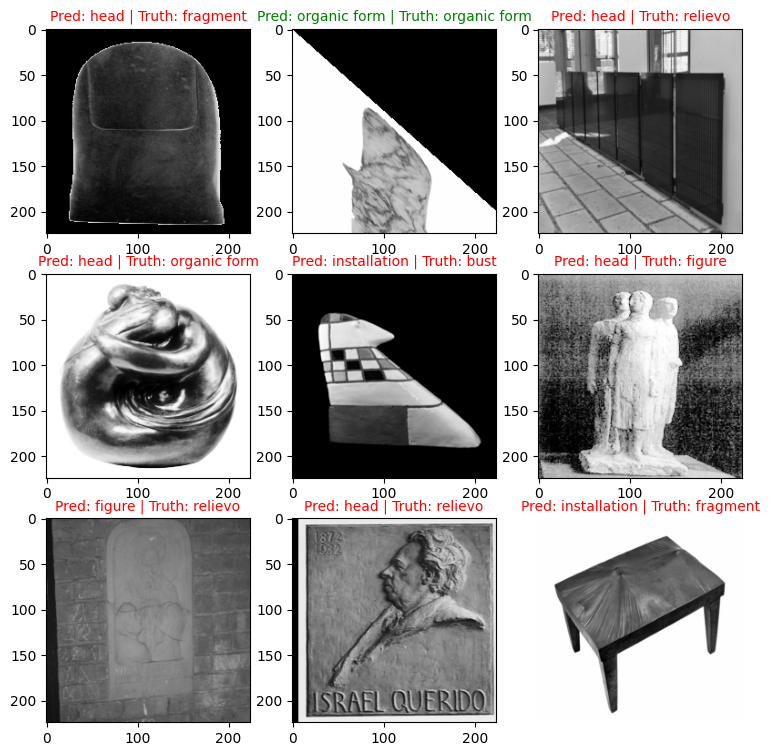

In [ ]:
# Plot predictions
import matplotlib.pyplot as plt
import numpy as np

# Create plot figure for 9 sample images
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # PLot the target image
  plt.imshow(sample.permute(1, 2, 0).numpy(), cmap="gray")

  # Find the pred label (in text form)
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form)
  truth_label = class_names[test_labels[i]]

  # Create a title for the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality between pred and truth and change color of title text
  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c="g") # if pred is true, title color turns green
  else:
    plt.title(title_text, fontsize=10, c="r") # if pred is false, title color turns red


plt.axis(False);

plt.show()


## 5. Metrics

### 5.1 Make predictions with trained model

In [ ]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_logit = model(X)
    # Turn predictions from logits -> pred prob -> pred labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    # Put preds on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concat list of preds into tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/4 [00:00<?, ?it/s]

### 5.2 Confusion matrix from torchmetrics mlxtend

In [ ]:
# Import mlxtend version 19 or higher to acces confusion matrix function
import torchmetrics, mlxtend
print(f"mlxtend version: {mlxtend.__version__}")
assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"


mlxtend version: 0.22.0


In [ ]:
# Turn list of predictions into tensor
y_pred_tensor = y_pred_tensor.type(torch.float)
y_pred_tensor.dtype

torch.float32

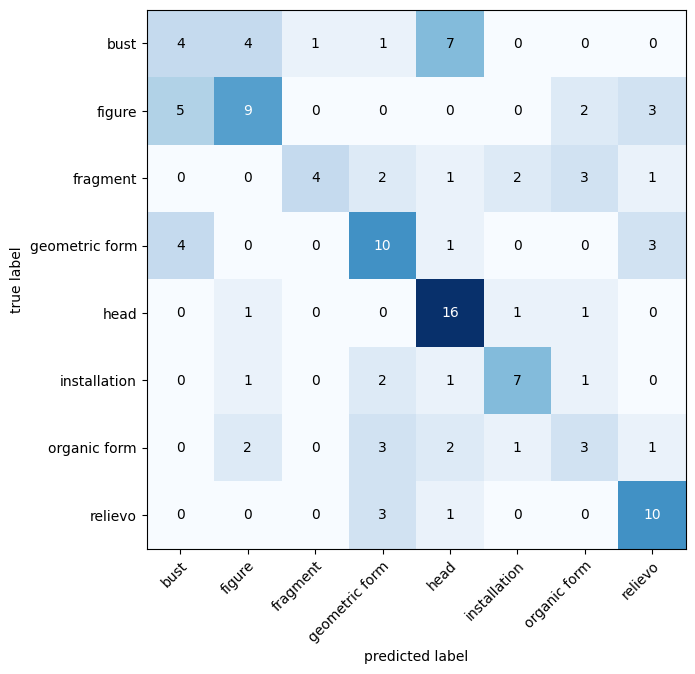

In [ ]:
from torchmetrics import ConfusionMatrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

# Setup the confusion matrix to compare the predictions to ground truth
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets)) # convert to tensor instead of list

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib works with numpy
    class_names=class_names, # rows and column labels are class names
    figsize=(10, 7)
);



### 5.3 Precision, recall, f1-score and accuracy

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Calculate the micro precision and recall using sklearn's functions
precision = precision_score(y_pred_tensor, torch.tensor(test_data.targets), average='micro')
recall = recall_score(y_pred_tensor, torch.tensor(test_data.targets), average='micro')
accuracy = accuracy_score(y_pred_tensor, torch.tensor(test_data.targets), normalize=True)

# Print the calculated precision and recall
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


Precision: 0.5080645161290323
Recall: 0.5080645161290323
Accuracy: 0.5080645161290323


In [ ]:
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

# Calculate the micro precision and recall using sklearn's classification report module
report = metrics.classification_report(y_pred=y_pred_tensor, y_true=torch.tensor(test_data.targets), target_names=class_names, zero_division=0)
# Print the calculated precision and recall
print(report)


                precision    recall  f1-score   support

          bust       0.29      0.29      0.29        17
        figure       0.43      0.47      0.45        19
      fragment       0.33      0.23      0.27        13
geometric form       0.53      0.50      0.51        18
          head       0.55      0.84      0.67        19
  installation       0.31      0.33      0.32        12
  organic form       0.33      0.17      0.22        12
       relievo       0.75      0.64      0.69        14

      accuracy                           0.46       124
     macro avg       0.44      0.44      0.43       124
  weighted avg       0.45      0.46      0.45       124

